# Modeling Spark Applications

Apache Spark is a very flexible distributed system. As a result of its flexibility, it is difficult to predict the total duration of different applications types. In this work, we use machine learning to find a model that can predict different application types. In the following sections, we analyze two applications: finding the Wikipedia top contributors (inspired by Spark Summit 2014) and HiBench Sort benchmark.

In [1]:
# Initial setup

try:
    plt_inline
except NameError:
    # Avoid small fonts when inlining again
    %matplotlib inline
    plt_inline = True
    
from inc.notebook000 import *

In [2]:
# 3 Apache Spark applications
APPS = ('wikipedia',      # Wikipedia application
        'hbsort',         # HiBench Sort benchmark
        'hbkmeans')       # HiBench K-means clustering benchmark
# 2 sets for every application:
SETS = ('profiling',      # less workers and input data to build the model
        'target')         # we want to predict this target set

# All DataFrames are stored in the "dfs" dictionary
dfs = {app: {s: {} for s in SETS} for app in APPS}

# Wikipedia's Top 10 Contributors
This application outputs the top 10 contributors of the English Wikipedia. The input is the information about the last version of all English Wikipedia articles in JSON format. In the article information, we can find who was the last person to edit it and this counts as one contribution for that person. We measured the first execution of a SQL query that returns the top 10 contributors.

In [3]:
dfb = DFBuilderWiki()

caption = 'Target executions that we want to predict, with different numbers of workers.' \
          ' Total input size is 45 GB.\n'
df = dfb.get_target()
dfs['wikipedia']['target']['original'] = helper.remove_outliers(df, Humanizer(), caption)

caption = 'Profiling executions with less workers and input data. They are used to generate the model.'
df = helper.get_wiki_profiling_df(dfb)
h = Humanizer(size=Humanizer.SIZE_MIB)
dfs['wikipedia']['profiling']['original'] = helper.remove_outliers(df, h, caption)

,workers,input size (GiB),mean (sec),samples,outliers,not outliers
0,4,45,184.20,30,2,28
1,8,45,103.31,30,1,29
2,16,45,64.58,30,2,28
3,32,45,43.88,30,2,28
4,64,45,39.23,30,1,29


Target executions that we want to predict, with different numbers of workers. Total input size is 45 GB.



,workers,input size (MiB),mean (sec),samples,outliers,not outliers
0,1,128,20.44,10,0,10
1,1,256,20.01,10,0,10
2,1,512,23.70,10,0,10
3,1,1024,29.96,10,0,10
4,2,1024,23.53,10,2,8
5,4,1024,20.85,10,0,10


Profiling executions with less workers and input data. They are used to generate the model.


# HB Sort
This is the Sort application from the HiBench suite. It sorts text input data, which is randomly generated. More details in its [GitHub page](https://github.com/intel-hadoop/HiBench) (there's also a paper about it with more details of the workload).

In [4]:
dfb = DFBuilderSort()
# Remove disk access
# TODO use prediction
df = dfb._get_all()
i = df.input
w = df.workers
dfb._all = df[(i != 3284983900) | (w != 1)]

caption = 'Target executions that we want to predict, with different numbers of workers.' \
          ' We used two problem sizes from the HiBench suite.\n'
df = helper.get_sort_target_df(dfb)
dfs['hbsort']['target']['original'] = helper.remove_outliers(df, Humanizer(), caption)

caption = 'Profiling executions with less workers and input data. They are used to generate the model.'
df = dfb.get_profiling()
h = Humanizer(size=Humanizer.SIZE_MIB)
dfs['hbsort']['profiling']['original'] = helper.remove_outliers(df, h, caption)

dfb.free()

,input size (GiB),workers,mean (sec),samples,outliers,not outliers
0,3,2,133.99,10,1,9
1,3,4,87.36,10,1,9
2,3,8,61.92,10,1,9
3,3,16,47.48,10,0,10
4,31,16,328.36,10,1,9
5,31,32,284.54,10,1,9
6,31,64,286.15,10,2,8
7,31,128,174.30,10,0,10


Target executions that we want to predict, with different numbers of workers. We used two problem sizes from the HiBench suite.



,input size (MiB),workers,mean (sec),samples,outliers,not outliers
0,263,1,31.24,10,1,9
1,263,2,26.29,10,1,9
2,526,1,49.05,10,2,8
3,526,2,36.14,10,0,10
4,526,4,27.77,10,1,9
5,1051,1,85.56,10,2,8
6,1051,2,54.80,10,3,7
7,1051,4,71.97,10,0,10
8,1051,8,29.82,10,0,10
9,2102,2,92.93,10,1,9


Profiling executions with less workers and input data. They are used to generate the model.


In [5]:
# Removing strange slow results in HB Sort with 1051 MB and 4 workers
# TODO outlier criteria

df = dfs['hbsort']['profiling']['original']
strange = (df.input > 10**9) & (df.input < 2 * 10**9) & (df.workers == 4)
dfs['hbsort']['profiling']['original'] = df[~strange]

# K-means Clustering

This is the K-means Clustering application from the HiBench suite. Input is the number of samples to split into K groups. More details in its [GitHub page](https://github.com/intel-hadoop/HiBench) (there's also a paper about it with more details of the workload).

In [6]:
dfb = DFBuilderK()
# Remove disk access
# TODO use prediction
i = dfb._df.input
w = dfb._df.workers
# Removing cases when memory is not enough (from notebook 001)
disk = ((i == 4096000) & (w <= 1)) | ((i == 16384000) & (w <= 4)) | ((i == 65536000) & (w <= 16))
dfb._df = dfb._df[~disk]

In [7]:
df = dfb.get_target()
caption = 'Target execution durations we want to predict.'
dfs['hbkmeans']['target']['original'] = helper.remove_outliers(df, caption=caption)

df = dfb.get_profiling()
caption = 'Profiling phase.'
dfs['hbkmeans']['profiling']['original'] = helper.remove_outliers(df, caption=caption)

dfb.free()

mean (sec)  samples  outliers  not outliers
input    workers                                             
16384000 8             61.45       10         0            10
         16            60.72       10         0            10
         32            52.55       10         0            10
65536000 32            74.69       10         0            10
         64            69.74       10         2             8
         128           72.06       10         1             9

Target execution durations we want to predict.


mean (sec)  samples  outliers  not outliers
input   workers                                             
32000   1             18.97       10         0            10
        2             17.72       10         2             8
        3             17.32       10         2             8
        4             18.88       10         0            10
        5             19.90       10         1             9
        6             20.97       10         0            10
        7             21.90       10         0            10
        8             23.26       10         1             9
64000   1             19.08       10         0            10
        2             18.60       10         0            10
        3             17.92       10         0            10
        4             19.13       10         0            10
        5             20.41       10         0            10
        6             21.32       10         0            10
        7             21.78       10         0            10
        8             22.56       10         0            10
128000  1             20.51       10         0            10
        2             19.37       10         0            10
        3             18.60       10         0            10
        4             19.71       10         0            10
        5             21.00       10         0            10
        6             21.29       10         0            10
        7             22.50       10         0            10
        8             22.42       10         0            10
256000  1             22.83       10         0            10
        2             21.02       10         0            10
        3             19.50       10         0            10
        4             20.57       10         0            10
        5             21.58       10         0            10
        6             22.76       10         2             8
        7             23.64       10         0            10
        8             24.39       10         0            10
512000  1             27.80       10         0            10
        2             24.19       10         0            10
        3             21.51       10         0            10
        4             22.68       10         0            10
        5             23.90       10         1             9
        6             24.85       10         0            10
        7             25.54       10         0            10
        8             25.99       10         0            10
1024000 1             36.55       10         0            10
        2             30.13       10         0            10
        3             24.90       10         0            10
        4             26.01       10         0            10
        5             27.64       10         1             9
        6             28.37       10         0            10
        7             28.60       10         0            10
        8             29.54       10         1             9
2048000 1             52.56       10         0            10
        2             40.73       10         0            10
        3             30.98       10         0            10
        4             32.07       10         0            10
        5             33.35       10         0            10
        6             34.46       10         0            10
        7             34.31       10         1             9
        8             35.25       10         0            10
4096000 2             55.40       10         0            10
        3             44.20       10         2             8
        4             42.52       10         0            10
        5             38.88       10         0            10
        6             39.74       10         0            10
        7             40.50       10         0            10
        8             42.60       10         1             9

Profiling phase.


# Models
We are going to try many (tens of thousands) different feature sets with Ridge penalized linear regression. There's also 5 different penalization multipliers (alpha values) that will be tested using cross validation (CV) for each feature set.

For each feature set, we train the model with the profiling experiment results and the best alpha is chosen. Then, we use the same model to predict the target executions' durations. Finally, we calculate 3 metrics for these predictions:
* MAE: Mean Absolut Error
* MPE: Mean Percentage Error
* RMSE: Root Mean Square Error

This is done for both applications and, based on these metrics, we will choose the best feature set to predict them.

## Linear Model and Features
In this section, we define the linear model and calculate other features than the number of workers and input size.

In [8]:
# Linear Regression with penalization to avoid overfitting
LINEAR_MODELS = (RidgeCV(normalize=True, alphas=(0.01, 0.1, 1, 3, 10)), linear_model.BayesianRidge(normalize=True))

DEGREE = 2  # columns "a" and "b" become "a", "a^2", "a*b", "b", "b^2"
_COMMON_COLS = [
    ('input', lambda df: df.input),
    ('workers', lambda df: df.workers),
    ('ms', lambda df: df.ms),  # this is not a feature, but the duration we want to predict
]

# Features to be added
COLS = _COMMON_COLS + [
    ('1/workers', lambda df: 1/df.workers),
    ('log(input_per_worker)', lambda df: np.log2(df.input/df.workers)),
    ('log(input)', lambda df: np.log2(df.input)),
    ('log(workers)', lambda df: np.log2(df.workers)),
]

# Features to predict the the duration log
COLS_LOG = _COMMON_COLS

In [9]:
# Pre-calculate all the features

for app in APPS:
    for s in SETS:
        df = dfs[app][s]
        df['features'] = helper.get_cols(df['original'], COLS, DEGREE)
        df['features_log'] = helper.get_log_cols(df['original'], COLS_LOG)

In [10]:
# Reducing the number of features, so we can analyze the results today.

df = dfs['wikipedia']['profiling']['features']
features = df.columns.tolist()
features.remove('ms')
n_features = len(features)
n_models = 2**n_features * len(LINEAR_MODELS)

print('Total number of features after polynomial expansion is {:d}. Feature\'s powerset cardinality is {:d} '
      'and it would take too long to compute.'.format(n_features, n_models))

removable_features = [
  'input * log(input_per_worker)',
  'input * log(input)',
  'input * log(workers)',
  'workers * 1/workers',
  'workers * log(input_per_worker)',
  'workers * log(input)',
  'workers * log(workers)',
  '1/workers * log(input_per_worker)',
  '1/workers * log(input)',
  '1/workers * log(workers)',
  'log(input_per_worker) * log(input)',
  'log(input_per_worker) * log(workers)']

for feature in removable_features:
    features.remove(feature)
n_features = len(features)
n_models = 2**n_features * len(LINEAR_MODELS)

print('\nAfter removing some features, we have {:d}. Feature\'s powerset cardinality is now {:d} '
      'and we are going to evaluate every feature subset. '
      'The final feature list is:\n    - {}'.format(n_features, n_models, '\n    - '.join(features)))

Total number of features after polynomial expansion is 27. Feature's powerset cardinality is 268435456 and it would take too long to compute.

After removing some features, we have 15. Feature's powerset cardinality is now 65536 and we are going to evaluate every feature subset. The final feature list is:
    - input
    - workers
    - 1/workers
    - log(input_per_worker)
    - log(input)
    - log(workers)
    - (input)^2
    - input * workers
    - input * 1/workers
    - (workers)^2
    - (1/workers)^2
    - (log(input_per_worker))^2
    - (log(input))^2
    - log(input) * log(workers)
    - (log(workers))^2


## Evaluation
For every possible feature combination, we calculate the errors MAE, MPE and RMSE for every application and set.

In [11]:
# Evaluation begins. This is the slowest cell. Good time for a coffee.

# All pandas' DataFrames are stored in the "dfs" dictionary.
eval_raw = {app: {s: {} for s in SETS} for app in APPS}

for app in APPS:
    prof = dfs[app]['profiling']['features']
    trgt = dfs[app]['target']['features']
    %time res = helper.evaluate_exp(prof, [prof, trgt], LINEAR_MODELS, features=features)
    eval_raw[app]['profiling'], eval_raw[app]['target'] = res

CPU times: user 25.3 s, sys: 353 ms, total: 25.6 s
Wall time: 4min 35s
CPU times: user 27.3 s, sys: 343 ms, total: 27.7 s
Wall time: 5min 6s
CPU times: user 28.5 s, sys: 620 ms, total: 29.2 s
Wall time: 5min 55s


In [12]:
# Now, a regression with logs using the duration log.

df = dfs['wikipedia']['profiling']['features_log']
features_log = [col for col in df.columns if col != 'log(ms)']
print('For regression with logs, we will use {:d} features: {}.\n'.format(
        len(features_log), ', '.join(features_log)))

for app in APPS:
    prof = dfs[app]['profiling']['features_log']
    trgt = dfs[app]['target']['features_log']
    res = helper.evaluate_exp(prof, [prof, trgt], LINEAR_MODELS, is_log=True)
    eval_raw[app]['profiling'] += res[0]
    eval_raw[app]['target'] += res[1]

For regression with logs, we will use 2 features: log(input), log(workers).



In [ ]:
# Sparse models
from lib import ModelEvaluator
import lib.modelcreator

kwargs = {'normalize': True, 'max_iter': 100000}
SPARSE_MODELS = (
    linear_model.Lasso(**kwargs),
    linear_model.LassoCV(**kwargs),
    linear_model.LassoLarsCV(**kwargs),
    linear_model.Lars(normalize=True),
    linear_model.LarsCV(**kwargs),
    linear_model.ElasticNet(**kwargs),
    linear_model.ElasticNetCV(**kwargs),
    linear_model.LassoLars(**kwargs)
)

all_features = dfs['wikipedia']['profiling']['features'].columns.tolist()
ycol = 'ms'
all_features.remove(ycol)
evaluator = ModelEvaluator()
for app in APPS:
    for linear_model in SPARSE_MODELS:
        prof = dfs[app]['profiling']['features']
        trgt = dfs[app]['target']['features']

        evaluator.set_fit_data(prof)
        model = lib.modelcreator.Model.copy_from(linear_model, all_features, ycol)
        res = evaluator.evaluate_model([prof, trgt], model)

        eval_raw[app]['profiling'] += (res[0],)
        eval_raw[app]['target'] += (res[1],)
        
all_features = dfs['wikipedia']['profiling']['features_log'].columns.tolist()
ycol = 'log(ms)'
all_features.remove(ycol)
evaluator = ModelEvaluator()
for app in APPS:
    for linear_model in SPARSE_MODELS:
        prof = dfs[app]['profiling']['features_log']
        trgt = dfs[app]['target']['features_log']

        evaluator.set_fit_data(prof)
        model = lib.modelcreator.Model.copy_from(linear_model, all_features, ycol)
        model.is_log = True
        res = evaluator.evaluate_model([prof, trgt], model)

        eval_raw[app]['profiling'] += (res[0],)
        eval_raw[app]['target'] += (res[1],)

In [16]:
%%time
# Create a DataFrame from the raw evaluation results

from multiprocessing.pool import Pool

def worker_format(app, s, res):
    formatted = helper.format_results(res)
    return app, s, formatted

def callback_format(res):
    app, s, formatted = res
    evaluation[app][s] = formatted

evaluation = {}
p = Pool()
for app in APPS:
    evaluation[app] = {}
    for s, res in eval_raw[app].items():
        p.apply_async(worker_format, (app, s, res), callback=callback_format)
p.close()
p.join()

CPU times: user 16.2 s, sys: 1.91 s, total: 18.1 s
Wall time: 2min 52s


In [18]:
%%time
# Create rank columns
from multiprocessing.pool import Pool


def get_rank(df, col):
    sorted_index = df.sort_values(col).index
    return [np.where(sorted_index == v)[0][0] for v in df.index]

errs = ('MAE', 'MPE', 'RMSE')
labels = ('value', 'rank')
index = pd.MultiIndex.from_product((APPS, SETS, errs, labels), names=['app', 'set', 'error', ''])
df_cmp = pd.DataFrame(columns=index)

def worker_get_rank(app, s, err, set_evaluation):
    index = (app, s, err, 'rank')
    rank = get_rank(set_evaluation, err)
    return index, rank

def callback_get_rank(res):
    index, rank = res
    df_cmp.loc[:, index] = rank
    
p = Pool()
for app in APPS:
    for s in SETS:
        for err in errs:
            df_cmp.loc[:, (app, s, err, 'value')] = evaluation[app][s][err]
            p.apply_async(worker_get_rank, (app, s, err, evaluation[app][s]),
                          callback=callback_get_rank)
p.close()
p.join()

CPU times: user 6.62 s, sys: 1.14 s, total: 7.76 s
Wall time: 1min 3s


To compare different metrics, we assign them ranks. The best model found for a given metric has rank 0. Then, we sort 
the models by the sum of all metrics' rank of all applications (target execution). Finally, we choose the first model, the one with the lowest sum.

In [19]:
mpe_values = (df_cmp.loc[:, (app, 'target', 'MPE', 'value')] for app in APPS)
mpe_max = pd.concat(mpe_values, axis=1).max(axis=1).sort_values()
mpe_max.index.name = 'model_nr'
display(pd.DataFrame({'max MPE': mpe_max}).head())

,max MPE
model_nr,
65544,23.74
273,32.47
1586,33.61
394,33.62
551,33.63


In [20]:
rank_sum = sum(df_cmp.loc[:, (app, 'target', err, 'rank')] for app in APPS for err in errs).sort_values()
rank_sum.index.name = 'model_nr'
display(pd.DataFrame({'rank sum': rank_sum}).head())

cols2drop = [(app, 'profiling') for app in APPS]
df_cmp.ix[rank_sum.index].drop(cols2drop, axis=1).head(10)

,rank sum
model_nr,
755,19412
192,19416
149,19458
65544,19492
1586,21744


/crypt/noBackup/repos/phd_notebook/venv/lib/python3.5/site-packages/ipykernel/kernelbase.py:390: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


app      wikipedia                               hbsort                    \
set         target                               target                     
error          MAE         MPE        RMSE          MAE         MPE         
             value  rank value  rank value  rank  value  rank value  rank   
model_nr                                                                    
755           3.16     2  4.12     2  4.03     3  16.43   149  9.48   186   
192           1.87     0  2.93     0  3.21     0  16.43   150  9.48   187   
149           2.34     1  3.30     1  3.37     1  16.43   151  9.48   188   
65544        19.33  3570 23.74  3024 21.92  3357  40.17  2057 17.47  1216   
1586          8.43  1938 14.79  1746  9.09  1669  80.07  5612 33.61  4723   
394           8.84  2207 15.13  1913  9.38  1953  80.05  5611 33.62  4727   
3302          7.96  1604 13.70  1249  8.53  1194  65.18  4310 27.08  2941   
551           8.99  2305 15.34  2035  9.52  2059  80.08  5614 33.63  4730   
1044          8.49  1984 14.33  1532  8.98  1581  65.02  4282 26.98  2914   
15698         8.25  1805 14.69  1705  8.99  1587  85.96  6217 36.31  5301   

app                   hbkmeans                                  
set                     target                                  
error      RMSE            MAE          MPE         RMSE        
          value  rank    value  rank  value  rank  value  rank  
model_nr                                                        
755       26.63   267    98.46  6368 142.82  6370 123.13  6065  
192       26.64   268    98.55  6370 142.94  6372 123.23  6069  
149       26.67   272    99.13  6380 143.78  6380 123.92  6084  
65544     57.86  2084    13.70  1397  21.19  1450  15.39  1337  
1586     111.91  5199     6.48   284   9.90   292   8.33   281  
394      111.90  5197     6.60   306  10.07   306   8.41   294  
3302      94.46  4383    25.69  2223  37.71  2205  37.43  2434  
551      111.93  5201     6.44   279   9.85   282   8.30   277  
1044      94.44  4381    25.78  2229  37.84  2209  37.44  2436  
15698    119.48  5695     7.02   366  10.49   350   9.51   525

The table on the top shows the sum of all ranks that are depicted in the second table. Both tables are sorted by the rank sum.

In [21]:
df_cmp.ix[rank_sum.index].head()

app      wikipedia                                                            \
set      profiling                                  target                     
error          MAE          MPE         RMSE           MAE         MPE         
             value   rank value   rank value   rank  value  rank value  rank   
model_nr                                                                       
755           0.89  19242  4.16  19197  1.26  18755   3.16     2  4.12     2   
192           0.89  19857  4.17  19591  1.26  25900   1.87     0  2.93     0   
149           0.89  19305  4.16  19137  1.26  20033   2.34     1  3.30     1   
65544         0.97  54749  4.47  49539  1.33  57483  19.33  3570 23.74  3024   
1586          0.88  10181  4.14   8701  1.26  23136   8.43  1938 14.79  1746   

app                     hbsort                                                \
set                  profiling                                  target         
error     RMSE             MAE          MPE         RMSE           MAE         
         value  rank     value   rank value   rank value   rank  value  rank   
model_nr                                                                       
755       4.03     3      1.64  16281  4.11  16571  2.11  16631  16.43   149   
192       3.21     0      1.64  16264  4.11  16567  2.11  16628  16.43   150   
149       3.37     1      1.63  15992  4.08  16490  2.11  16593  16.43   151   
65544    21.92  3357      1.91  16865  4.39  16784  2.45  17007  40.17  2057   
1586      9.09  1669      2.74  17063  6.46  17063  3.18  17054  80.07  5612   

app                                hbkmeans                                   \
set                               profiling                                    
error      MPE         RMSE             MAE          MPE         RMSE          
         value  rank  value  rank     value   rank value   rank value   rank   
model_nr                                                                       
755       9.48   186  26.63   267      2.03  51843  7.91  55465  2.45  47047   
192       9.48   187  26.64   268      2.03  51880  7.92  55501  2.45  47072   
149       9.48   188  26.67   272      2.03  51865  7.92  55482  2.45  47075   
65544    17.47  1216  57.86  2084      5.36  65351 19.98  65351  6.74  65343   
1586     33.61  4723 111.91  5199      1.33  31287  5.11  31380  1.70  31482   

app                                              
set      target                                  
error       MAE          MPE         RMSE        
          value  rank  value  rank  value  rank  
model_nr                                         
755       98.46  6368 142.82  6370 123.13  6065  
192       98.55  6370 142.94  6372 123.23  6069  
149       99.13  6380 143.78  6380 123.92  6084  
65544     13.70  1397  21.19  1450  15.39  1337  
1586       6.48   284   9.90   292   8.33   281

As we can see in the profiling evaluation results, the best models to predict the target executions are not the best ones to predict the profiling durations. Thus, by only making a regression in the profiling results, one would have worse predictions. That is why we need to choose a model by analyzing the target scores.

## Best Models

Now, we visualize the chosen model for both applications. The model details are:

In [23]:
def plot_wikipedia(model):
    prof = dfs['wikipedia']['profiling']['features']
    trgt = dfs['wikipedia']['target']['features']
    model.fit(prof)
    plotter = Plotter(xlim=(3, 65))
    plotter.plot_model(model, trgt)
    print('Prediction of the Wikipedia application target execution duration.')
    
def plot_hbsort(model):
    prof = dfs['hbsort']['profiling']['features']
    trgt = dfs['hbsort']['target']['features']
    model.fit(prof)
    plotter = Plotter(xlim=(0.75, 16.25))
    plotter.plot_model(model, trgt[trgt.input < 15 * 1024**3])
    plotter = Plotter(xlim=(14, 130))
    plotter.plot_model(model, trgt[trgt.input > 15 * 1024**3])
    print('The top figure is the result of the HiBench Sort application with 3-GB input.'
          'The second figure uses 31-GB of data.')
    
def plot_hbkmeans(model):
    prof = dfs['hbkmeans']['profiling']['features']
    trgt = dfs['hbkmeans']['target']['features']
    model.fit(prof)
    plotter = Plotter(xlim=(7.5, 32.5))
    plotter.plot_model(model, trgt[trgt.input == 16384000])
    plotter = Plotter(xlim=(30, 130))
    plotter.plot_model(model, trgt[trgt.input == 65536000])
    print('The top figure is the result of the HiBench K-means application with 16,384,000 samples.'
          'The second figure uses 65,536,000 samples.')

def visualize_model_nr(model_nr):
    print('Model number {}:'.format(model_nr))
    model = pickle.loads(eval_raw['wikipedia']['target'][model_nr]['model_dump'])
    print(str(model))
    
    plot_wikipedia(model)
    plot_hbsort(model)
    plot_hbkmeans(model)
    
def visualize_model_rank(rank):
    print('Model with rank {}:'.format(rank))
    model_nr = rank_sum.index[rank]
    visualize_model_nr(model_nr)

Model with rank 1:
Model number 192:
      linear model: RidgeCV
      duration log: False
            params: alphas: (0.01, 0.1, 1, 3, 10), best: 0.01
number of features: 3
          features: input, input * 1/workers, (log(input_per_worker))^2


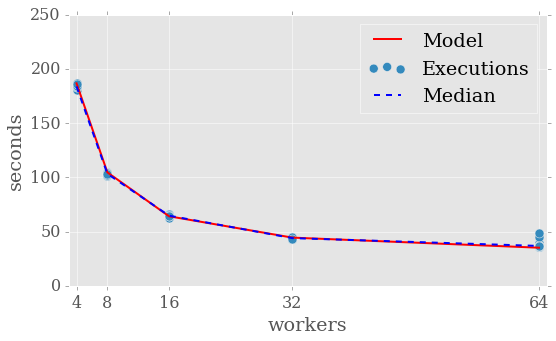

Prediction of the Wikipedia application target execution duration.


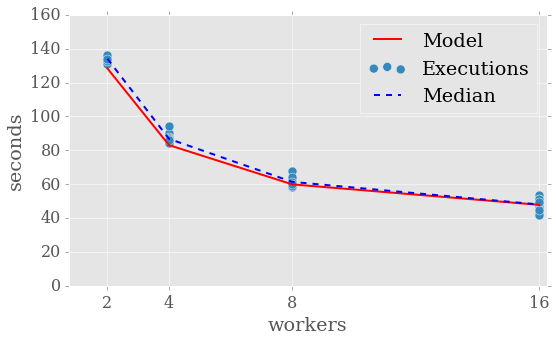

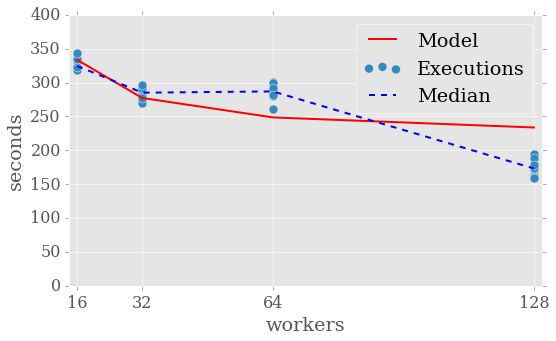

The top figure is the result of the HiBench Sort application with 3-GB input.The second figure uses 31-GB of data.


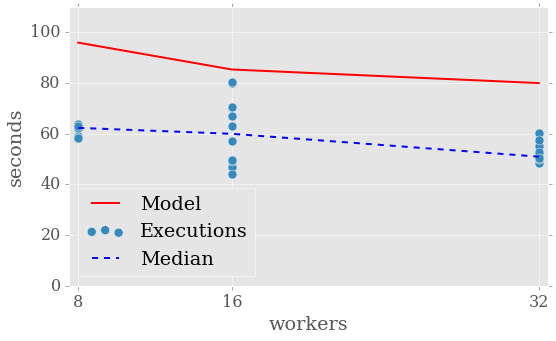

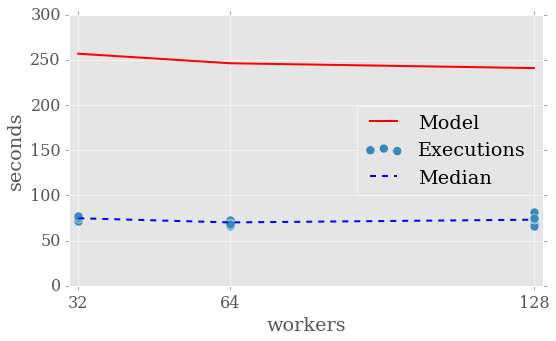

The top figure is the result of the HiBench K-means application with 16,384,000 samples.The second figure uses 65,536,000 samples.


In [24]:
visualize_model_rank(1)

Model number 1586:
      linear model: RidgeCV
      duration log: False
            params: alphas: (0.01, 0.1, 1, 3, 10), best: 0.01
number of features: 4
          features: log(input_per_worker), input * 1/workers, (log(input_per_worker))^2, (log(workers))^2


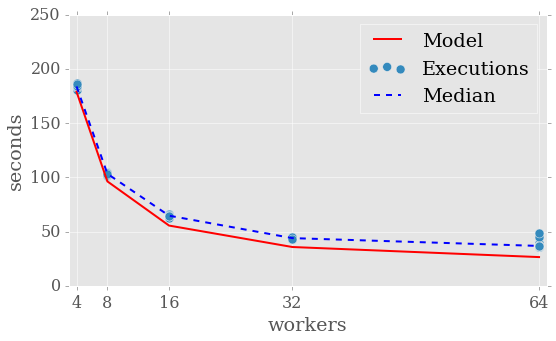

Prediction of the Wikipedia application target execution duration.


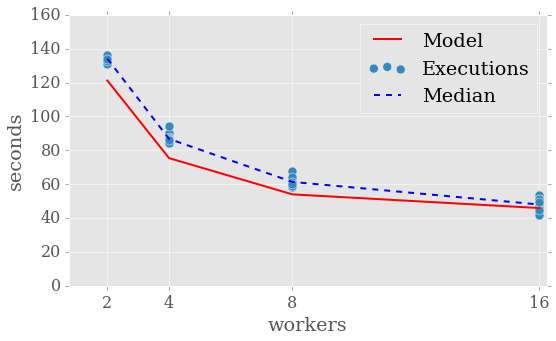

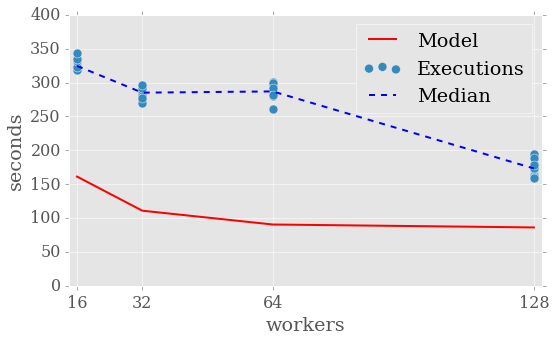

The top figure is the result of the HiBench Sort application with 3-GB input.The second figure uses 31-GB of data.


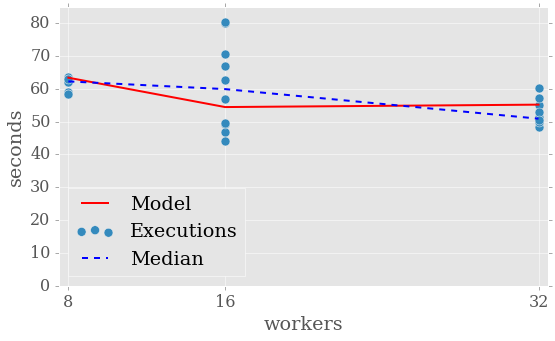

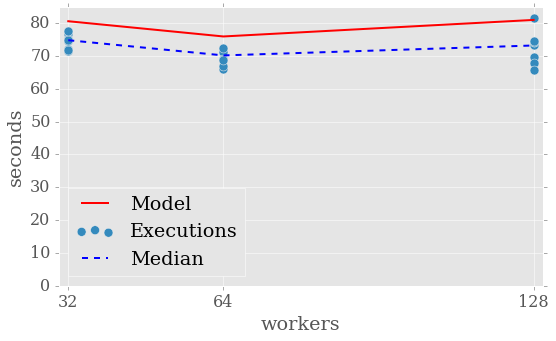

The top figure is the result of the HiBench K-means application with 16,384,000 samples.The second figure uses 65,536,000 samples.


In [25]:
visualize_model_nr(1586)

Model number 553:
      linear model: RidgeCV
      duration log: False
            params: alphas: (0.01, 0.1, 1, 3, 10), best: 0.01
number of features: 3
          features: input * 1/workers, (log(input))^2, (log(workers))^2


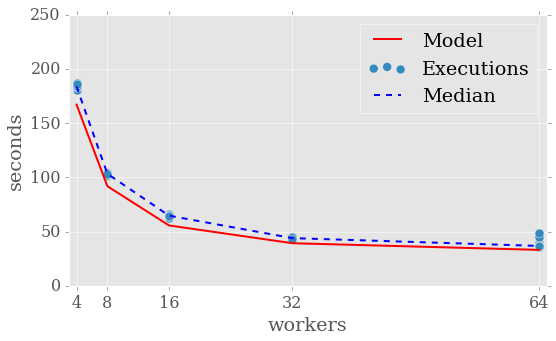

Prediction of the Wikipedia application target execution duration.


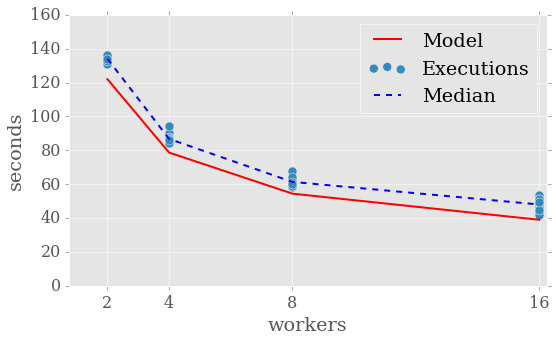

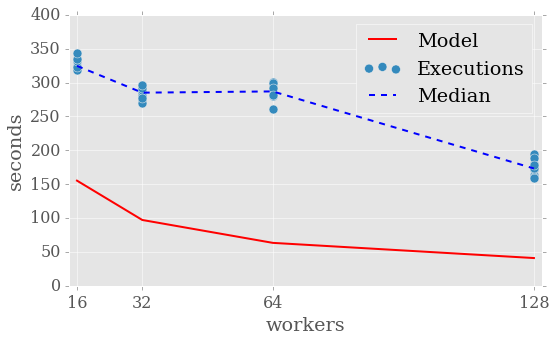

The top figure is the result of the HiBench Sort application with 3-GB input.The second figure uses 31-GB of data.


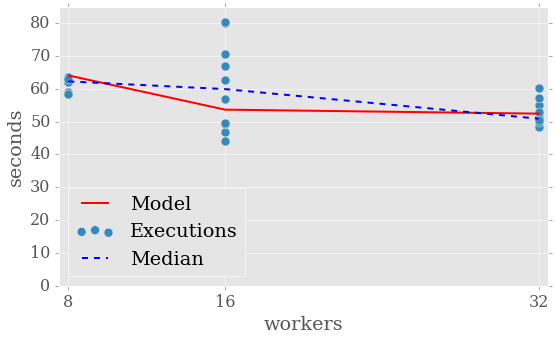

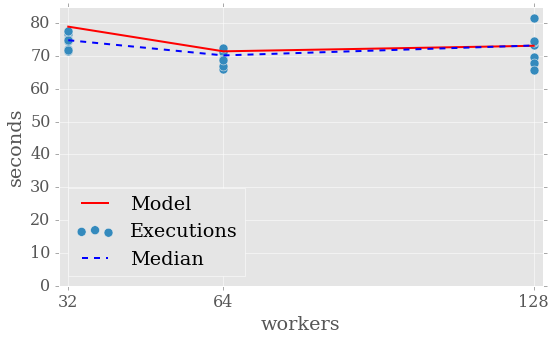

The top figure is the result of the HiBench K-means application with 16,384,000 samples.The second figure uses 65,536,000 samples.


In [26]:
visualize_model_nr(553)

Model number 1709:
      linear model: RidgeCV
      duration log: False
            params: alphas: (0.01, 0.1, 1, 3, 10), best: 0.01
number of features: 4
          features: log(input), input * 1/workers, log(input) * log(workers), (log(workers))^2


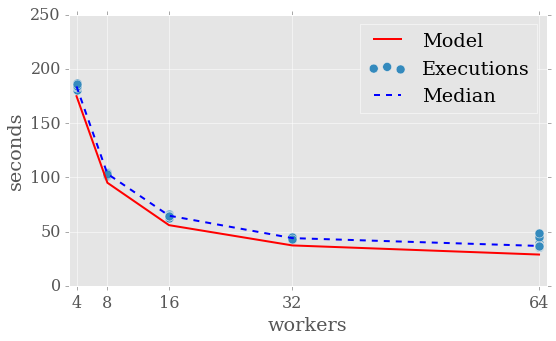

Prediction of the Wikipedia application target execution duration.


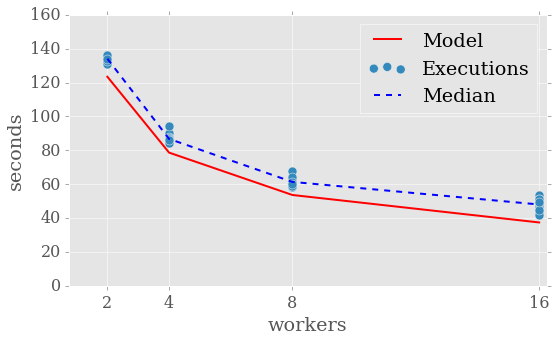

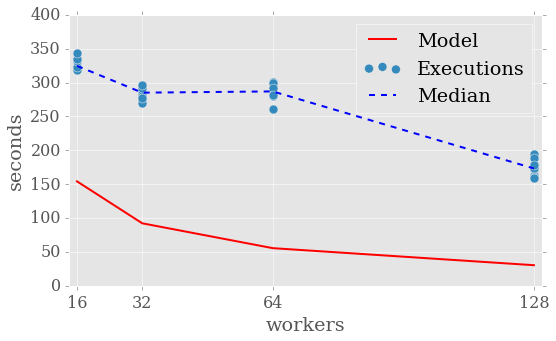

The top figure is the result of the HiBench Sort application with 3-GB input.The second figure uses 31-GB of data.


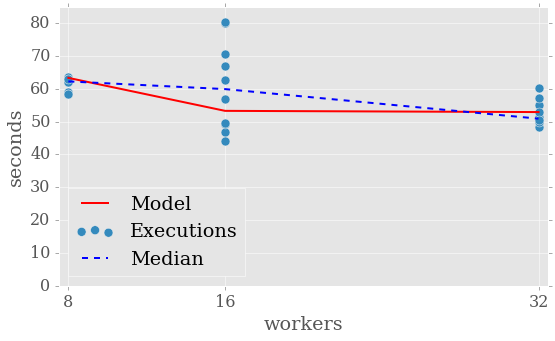

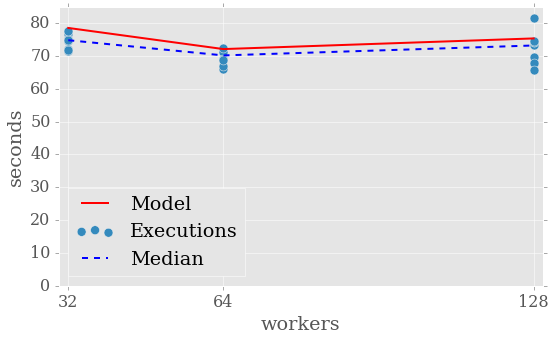

The top figure is the result of the HiBench K-means application with 16,384,000 samples.The second figure uses 65,536,000 samples.


In [27]:
visualize_model_nr(1709)

Model number 65544:
      linear model: LarsCV
      duration log: False
            params: copy_X: True, cv: None, eps: 2.220446049250313e-16, fit_intercept: True, max_iter: 100000, max_n_alphas: 1000, n_jobs: 1, normalize: True, positive: False, precompute: auto, verbose: False
number of features: 27
          features: input, workers, 1/workers, log(input_per_worker), log(input), log(workers), (input)^2, input * workers, input * 1/workers, input * log(input_per_worker), input * log(input), input * log(workers), (workers)^2, workers * 1/workers, workers * log(input_per_worker), workers * log(input), workers * log(workers), (1/workers)^2, 1/workers * log(input_per_worker), 1/workers * log(input), 1/workers * log(workers), (log(input_per_worker))^2, log(input_per_worker) * log(input), log(input_per_worker) * log(workers), (log(input))^2, log(input) * log(workers), (log(workers))^2


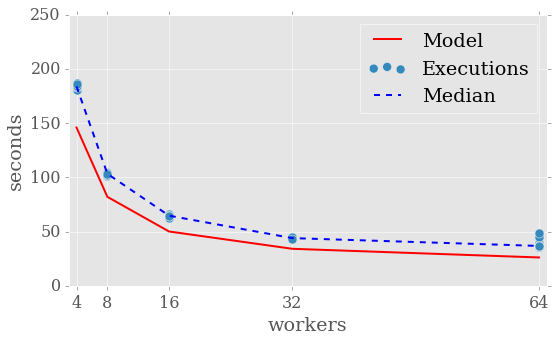

Prediction of the Wikipedia application target execution duration.


/crypt/noBackup/repos/phd_notebook/venv/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.054e+02, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
/crypt/noBackup/repos/phd_notebook/venv/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.039e+02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.980e-08
  ConvergenceWarning)
/crypt/noBackup/repos/phd_notebook/venv/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.032e+02, with an active set of 7 regressors, and the smallest cholesky pivot element being 

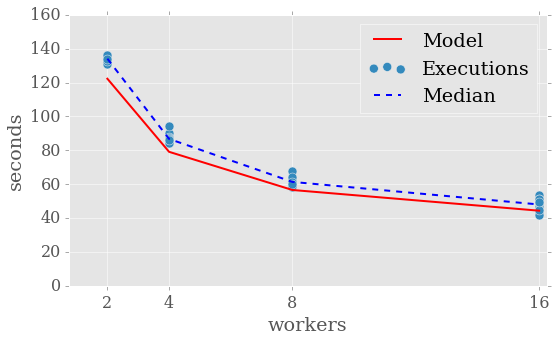

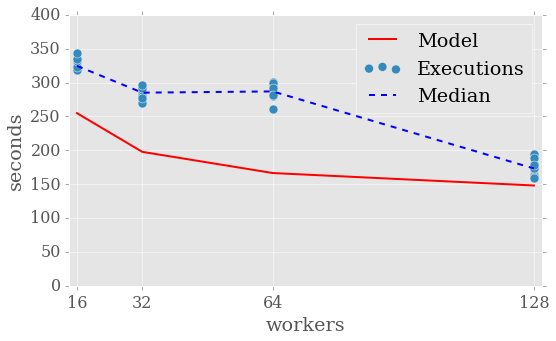

The top figure is the result of the HiBench Sort application with 3-GB input.The second figure uses 31-GB of data.


/crypt/noBackup/repos/phd_notebook/venv/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 33 iterations, i.e. alpha=6.142e+02, with an active set of 24 regressors, and the smallest cholesky pivot element being 6.322e-08
  ConvergenceWarning)
/crypt/noBackup/repos/phd_notebook/venv/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 33 iterations, i.e. alpha=2.079e+02, with an active set of 24 regressors, and the smallest cholesky pivot element being 6.322e-08
  ConvergenceWarning)
/crypt/noBackup/repos/phd_notebook/venv/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=7.400e+01, with an active set of 11 regressors, and the smallest cholesky pivot element 

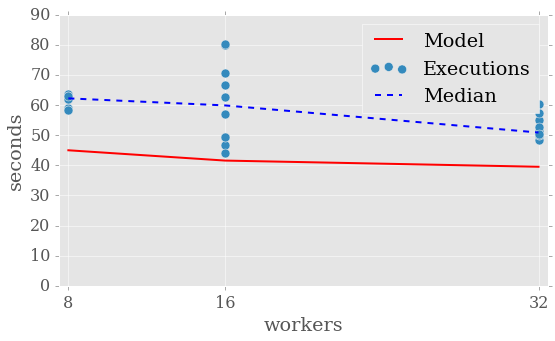

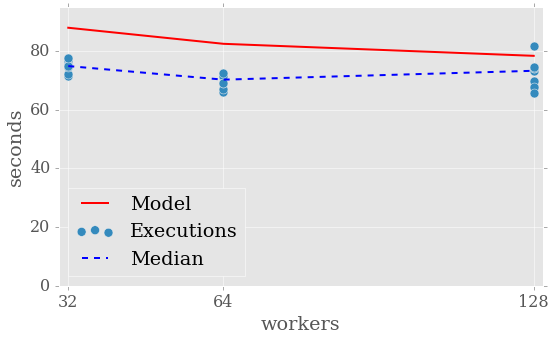

The top figure is the result of the HiBench K-means application with 16,384,000 samples.The second figure uses 65,536,000 samples.


In [28]:
visualize_model_nr(65544)

# Conclusion
There are two major findings in this work. One is that the best model to predict the profiling set performs poorly in the target prediction. The other is that, despite of being two different applications, we were able to find one model that has good results for all target number of workers of the Wikipedia application and also for the HiBench Sort benchmark, from 2 to 64 workers using 3 and 31 GB of input data.